In [10]:
import numpy as np
from astropy.io import ascii


# Read UHECR
filename_e = '../data/Auger/events_a8_lb.dat'
events_a8 = ascii.read(filename_e)

# Read Gxs
filename_g = '../data/VLS/2MRSxWISE_VLS.txt'
data = ascii.read(filename_g)

data_decmin, data_decmax = data['_DEJ2000'].min(),data['_DEJ2000'].max()
data_ramin, data_ramax = data['_RAJ2000'].min(),data['_RAJ2000'].max()
print('Gxs DEC range:%5.2fdeg - %5.2fdeg' % (data_decmin,data_decmax))
print('Gxs RA range:%5.2fdeg - %5.2fdeg' % (data_ramin, data_ramax))

print('UHECR DEC range:%5.2fdeg - %5.2fdeg' % (events_a8['dec'].min(),events_a8['dec'].max()))
print('UHECR RA range:%5.2fdeg - %5.2fdeg' % (events_a8['RA'].min(),events_a8['RA'].max()))

data.keys()


Gxs DEC range:-87.77deg - 44.95deg
Gxs RA range: 0.81deg - 359.86deg
UHECR DEC range:-89.90deg - 44.70deg
UHECR RA range: 0.00deg - 360.00deg


['_RAJ2000',
 '_DEJ2000',
 'Kcmag',
 'Hcmag',
 'Jcmag',
 'Ktmag',
 'K_abs',
 'type',
 'cz',
 'JNAME',
 'W1mag',
 'W2mag',
 'W3mag',
 'class']

#### Autocorrelation

In [11]:
from nbodykit.lab import *

datacat = ArrayCatalog(data)#, names=['_RAJ2000','_DEJ2000','Kcmag','Hcmag','Jcmag','Ktmag','K_abs','type','cz','JNAME','W1mag','W2mag','W3mag','class'])
rancat = RandomCatalog(len(datacat)*50, seed=42)
rancat['_RAJ2000']  = rancat.rng.uniform(low=data_ramin, high=data_ramax)
rancat['_DEJ2000'] = rancat.rng.uniform(low=data_decmin, high=data_decmax)

nbins = 15
bins = np.linspace(10., 90., nbins+1)

r_auto = SurveyData2PCF(mode='angular',data1=datacat, randoms1=rancat, \
                        edges=bins, ra='_RAJ2000', dec='_DEJ2000')



[0.00558545 0.00438627 0.0036692  0.00320913 0.00293788 0.00265732
 0.00238543 0.00215278 0.00194198 0.0017991  0.00169067 0.0016761
 0.00170321 0.00184464 0.00187429]


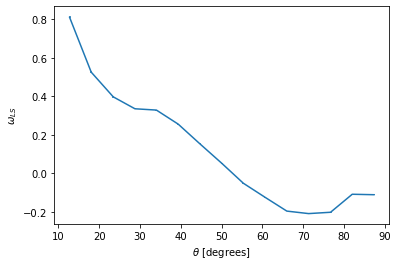

In [12]:

import matplotlib.pyplot as plt

#Poisson noise
pnoise = (1+r_auto.corr['corr'])/np.sqrt(r_auto.D1D2['npairs'])
print(pnoise)

plt.errorbar(r_auto.corr['theta'],r_auto.corr['corr'],yerr=pnoise)

plt.xlabel(r"$\theta$ [$\mathrm{degrees}$]")
plt.ylabel(r"$\omega_{LS}$")
plt.show()

np.savez('../data/nbodykit.npz',r_auto.corr['theta'],r_auto.corr['corr'],pnoise)

#### Landy-Szalay Estimator: $\omega_{LS}:=(\frac{DD}{N_D(N_D-1)}-\frac{2DR}{N_DN_R}+\frac{RR}{N_R(N_R-1)})/\frac{RR}{N_R(N_R-1)}$

[ 0.81956631  0.52515095  0.3974389   0.33276098  0.32692438  0.25565014
  0.15506648  0.04053001 -0.06958128 -0.13221598 -0.20197666 -0.21432228
 -0.19848736 -0.10000608 -0.10103254]
[ 0.81956631  0.52515095  0.3974389   0.33276098  0.32692438  0.25565014
  0.15506648  0.04053001 -0.06958128 -0.13221598 -0.20197666 -0.21432228
 -0.19848736 -0.10000608 -0.10103254]
Hago esto para chequear que el codigo normalice bien


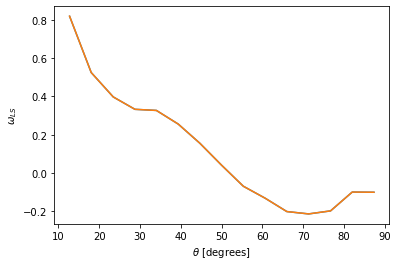

In [4]:
Nd = len(datacat)
Nr = len(rancat)

DD = r_auto.D1D2['npairs'].astype(np.float)/(Nd*(Nd-1))
DR = r_auto.D1R2['npairs'].astype(np.float)/(Nd*Nr)
RR = r_auto.R1R2['npairs'].astype(np.float)/(Nr*(Nr-1))



ls = (DD-2*DR+RR)/RR
print(ls)

print(r_auto.corr['corr'])

print('Hago esto para chequear que el codigo normalice bien')

plt.plot(r_auto.corr['theta'],r_auto.corr['corr'])
plt.plot(r_auto.corr['theta'],ls)

plt.xlabel(r"$\theta$ [$\mathrm{degrees}$]")
plt.ylabel(r"$\omega_{LS}$")
plt.show()



#### Autocorrelacion de randoms

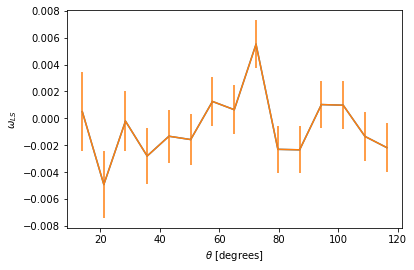

In [5]:
nbins = 15
bins = np.linspace(10., 120., nbins+1)

rancat2 = RandomCatalog(len(datacat), seed=43)
rancat2['_RAJ2000']  = rancat2.rng.uniform(low=data_ramin, high=data_ramax)
rancat2['_DEJ2000'] = rancat2.rng.uniform(low=data_decmin, high=data_decmax)

r_auto = SurveyData2PCF(mode='angular',data1=rancat2, randoms1=rancat, \
                        edges=bins, ra='_RAJ2000', dec='_DEJ2000')


#Poisson noise
pnoise = (1+r_auto.corr['corr'])/np.sqrt(r_auto.D1D2['npairs'])

plt.plot(r_auto.corr['theta'],r_auto.corr['corr'])

plt.errorbar(r_auto.corr['theta'],r_auto.corr['corr'],yerr=pnoise)

plt.xlabel(r"$\theta$ [$\mathrm{degrees}$]")
plt.ylabel(r"$\omega_{LS}$")
plt.show()

#### Crosscorrelation

In [2]:
import numpy as np
from nbodykit.lab import *

nmult = 10 # N_r/N_d
nbins = 15 # num of bins of theta
minth, maxth = 10., 90. # min/max values of theta

datacat = ArrayCatalog(data)#, names=['_RAJ2000','_DEJ2000','Kcmag','Hcmag','Jcmag','Ktmag','K_abs','type','cz','JNAME','W1mag','W2mag','W3mag','class'])
eventscat = ArrayCatalog(events_a8)#, names=['_RAJ2000','_DEJ2000','Kcmag','Hcmag','Jcmag','Ktmag','K_abs','type','cz','JNAME','W1mag','W2mag','W3mag','class'])

data_decmin, data_decmax = data['_DEJ2000'].min(),data['_DEJ2000'].max()
data_ramin, data_ramax = data['_RAJ2000'].min(),data['_RAJ2000'].max()
print('Gxs DEC range:%5.2fdeg - %5.2fdeg' % (data_decmin,data_decmax))
print('Gxs RA range:%5.2fdeg - %5.2fdeg' % (data_ramin, data_ramax))

eve_decmin, eve_decmax = events_a8['dec'].min(),events_a8['dec'].max()
eve_ramin, eve_ramax = events_a8['RA'].min(),events_a8['RA'].max()
print('UHECR DEC range:%5.2fdeg - %5.2fdeg' % (eve_ramin, eve_ramax))
print('UHECR RA range:%5.2fdeg - %5.2fdeg' % (eve_ramin, eve_ramax))


datacat['RA'] = datacat['_RAJ2000']
datacat['DEC'] = datacat['_DEJ2000']
eventscat['DEC'] = eventscat['dec']

################################################################################

rancat1 = RandomCatalog(len(datacat)*nmult, seed=42)
rancat1['RA']  = rancat1.rng.uniform(low=data_ramin, high=data_ramax)
rancat1['DEC'] = rancat1.rng.uniform(low=data_decmin, high=data_decmax)


rancat2 = RandomCatalog(len(eventscat)*nmult, seed=43)
rancat2['RA']  = rancat2.rng.uniform(low=eve_ramin, high=eve_ramax)
rancat2['DEC'] = rancat2.rng.uniform(low=eve_decmin, high=eve_decmax)


bins = np.linspace(minth, maxth, nbins+1)

r_cross = SurveyData2PCF(mode='angular',\
                        data1=datacat, randoms1=rancat1,\
                        data2=eventscat, randoms2=rancat1,\
                        edges=bins, ra='RA', dec='DEC')

################################################################################


import matplotlib.pyplot as plt

plt.plot(r_cross.corr['theta'],r_cross.corr['corr'])

plt.xlabel(r"$\theta$ [$\mathrm{degrees}$]")
plt.ylabel(r"$\xi_{LS}$")
plt.show()

KeyboardInterrupt: 

##### Bright/Faint Crosscorrelation

In [7]:
import numpy as np
from astropy.io import ascii
from nbodykit.lab import *


# Read UHECR
filename_e = '../data/Auger/events_a8_lb.dat'
events_a8 = ascii.read(filename_e)

# Read Gxs
filename_g = '../data/VLS/2MRSxWISE_VLS.txt'
data = ascii.read(filename_g)

data_decmin, data_decmax = data['_DEJ2000'].min(),data['_DEJ2000'].max()
data_ramin, data_ramax = data['_RAJ2000'].min(),data['_RAJ2000'].max()
print('Gxs DEC range:%5.2fdeg - %5.2fdeg' % (data_decmin,data_decmax))
print('Gxs RA range:%5.2fdeg - %5.2fdeg' % (data_ramin, data_ramax))

print('UHECR DEC range:%5.2fdeg - %5.2fdeg' % (events_a8['dec'].min(),events_a8['dec'].max()))
print('UHECR RA range:%5.2fdeg - %5.2fdeg' % (events_a8['RA'].min(),events_a8['RA'].max()))

##################################################################################################

data_bright = data[(data['K_abs']<-23.2)&(data['K_abs']>-26.)]
data_faint = data[(data['K_abs']>-23.2)&(data['K_abs']<-22.)]

#Get min and max for RA and DEC in both samples
data_bright_decmin = data_bright['_DEJ2000'].min()
data_bright_decmax = data_bright['_DEJ2000'].max()
data_bright_ramin = data_bright['_RAJ2000'].min()
data_bright_ramax = data_bright['_RAJ2000'].max()
data_faint_decmin = data_faint['_DEJ2000'].min()
data_faint_decmax = data_faint['_DEJ2000'].max()
data_faint_ramin = data_faint['_RAJ2000'].min()
data_faint_ramax = data_faint['_RAJ2000'].max()


brightcat = ArrayCatalog(data_bright)
faintcat = ArrayCatalog(data_faint)
eventscat = ArrayCatalog(events_a8)

brightcat['RA'] = brightcat['_RAJ2000']
brightcat['DEC'] = brightcat['_DEJ2000']
faintcat['RA'] = faintcat['_RAJ2000']
faintcat['DEC'] = faintcat['_DEJ2000']
eventscat['DEC'] = eventscat['dec']


"""
Generating random catalogues
"""
rancat_b = RandomCatalog(len(brightcat)*10, seed=42)
rancat_b['RA']  = rancat_b.rng.uniform(low=data_bright_ramin, high=data_bright_ramax)
rancat_b['DEC'] = rancat_b.rng.uniform(low=data_bright_decmin, high=data_bright_decmax)


rancat_f = RandomCatalog(len(faintcat)*10, seed=43)
rancat_f['RA']  = rancat_f.rng.uniform(low=data_faint_ramin, high=data_faint_ramax)
rancat_f['DEC'] = rancat_f.rng.uniform(low=data_faint_decmin, high=data_faint_decmax)

#################################################################################################


Gxs DEC range:-87.77deg - 44.95deg
Gxs RA range: 0.81deg - 359.86deg
UHECR DEC range:-89.90deg - 44.70deg
UHECR RA range: 0.00deg - 360.00deg


In [8]:


nbins = 15
bins = np.linspace(10., 90., nbins+1)

r_cross_b = SurveyData2PCF(mode='angular',\
                        data1=brightcat, randoms1=rancat_b,\
                        data2=eventscat, randoms2=rancat_f,\
                        edges=bins, ra='RA', dec='DEC')

r_cross_f = SurveyData2PCF(mode='angular',\
                        data1=faintcat, randoms1=rancat_b,\
                        data2=eventscat, randoms2=rancat_f,\
                        edges=bins, ra='RA', dec='DEC')

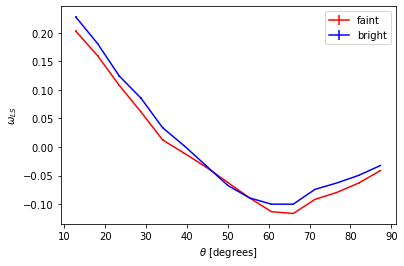

In [11]:
import matplotlib.pyplot as plt

Nd1 = len(data_bright)
Nd2 = len(events_a8)
Nr = len(rancat_b)

# D1D2 = r_cross_b.D1D2['npairs'].astype(np.float)/(Nd1*Nd2)
# D1R = r_cross_b.D1R2['npairs'].astype(np.float)/(Nd1*Nr)
# D2R = r_cross_b.D2R1['npairs'].astype(np.float)/(Nd2*Nr)
# RR = r_cross_b.R1R2['npairs'].astype(np.float)/(Nr*(Nr-1))

# #LS = D1D2-D1R-D2R+RR / RR
# ls = (D1D2-D1R-D2R+RR)/RR

pnoise_b = (1+r_cross_b.corr['corr'])/np.sqrt(r_cross_b.D1D2['npairs'])
pnoise_f = (1+r_cross_f.corr['corr'])/np.sqrt(r_cross_f.D1D2['npairs'])

plt.errorbar(r_cross_f.corr['theta'],r_cross_f.corr['corr'],yerr=pnoise_f,label='faint',c='r')
plt.errorbar(r_cross_b.corr['theta'],ls,yerr=pnoise_b,label='bright',c='b')

#plt.plot(r_cross_f.corr['theta'],r_cross_f.corr['corr'],label='faint',c='r')
#plt.plot(r_cross_b.corr['theta'],r_cross_b.corr['corr'],label='bright',c='b')

plt.legend()
plt.xlabel(r"$\theta$ [$\mathrm{degrees}$]")
plt.ylabel(r"$\omega_{LS}$")
plt.savefig('../data/cross_nbodykit_bf.png')
plt.show()

np.savez('../data/nbodykit_cross_bright.npz',r_cross_b.corr['theta'],r_cross_b.corr['corr'],pnoise_b)
np.savez('../data/nbodykit_cross_faint.npz',r_cross_f.corr['theta'],r_cross_f.corr['corr'],pnoise_f)